# Learning pytorch with CNN and the CIFAR10 dataset

In [1]:
import os
import numpy as np
import torchvision.models.segmentation
import torch
import torchvision.transforms as tf
from torch.utils.data import Dataset
import cv2
from torch.utils import data
import matplotlib.pyplot as plt


## Initialize dataset class

In [2]:
# Create custom dataset class
class SegNetDataset(Dataset):
	def __init__(self, root_dir, transform=None):
		self.root_dir = root_dir
		self.transform = transform
		self.images = os.listdir(os.path.join(root_dir, 'color-input'))
		self.masks = os.listdir(os.path.join(root_dir, 'label'))

	def __len__(self):
		return len(self.images)

	def __getitem__(self, idx):
		img_path = os.path.join(self.root_dir, 'color-input', self.images[idx])
		mask_path = os.path.join(self.root_dir, 'label', self.masks[idx])
		image = cv2.imread(img_path)
		mask = cv2.imread(mask_path)
		if self.transform:
			image = self.transform(image)
			mask = self.transform(mask)
		return image, mask

## Import necessary packages

In [9]:
from torch.nn import Conv2d, ReLU, BatchNorm2d, ConvTranspose2d, MaxPool2d, Module, ModuleList, Sequential, Upsample, Softmax, CrossEntropyLoss

## Define the encoder and decoder classes of U-Net

In [8]:
class UNet(Module):
    def encode_block(self, in_channels, out_channels, kernel_size=3):
        enc_block = Sequential(            
            Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=1),
            ReLU(),
            BatchNorm2d(out_channels),
            Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, padding=1),
            ReLU(),
            BatchNorm2d(out_channels)
        )
        return enc_block

    def bottle_neck(self, in_channels, out_channels, kernel_size=3):
        bottle_neck_block = Sequential(
            Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=1),
            ReLU(),
            BatchNorm2d(out_channels),
            Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, padding=1),
            ReLU(),
            BatchNorm2d(out_channels),
            ConvTranspose2d(in_channels=out_channels, out_channels=in_channels, kernel_size=kernel_size, stride=2, padding=1, output_padding=1)
        )
        return bottle_neck_block

    def decode_block(self, in_channels, mid_channel, out_channels, kernel_size=3):
        dec_block = Sequential(
            Conv2d(in_channels=in_channels, out_channels=mid_channel, kernel_size=kernel_size),
            ReLU(),
            BatchNorm2d(mid_channel),
            Conv2d(in_channels=mid_channel, out_channels=mid_channel, kernel_size=kernel_size),
            ReLU(),
            BatchNorm2d(mid_channel),
            ConvTranspose2d(in_channels=mid_channel, out_channels=out_channels, kernel_size=kernel_size, stride=2, padding=1, output_padding=1)
        )
        return dec_block


    def __init__(self, in_channels, out_channels, kernel_size=3):
        super.__init__()
        # Encode
        self.encode_block1 = self.encode_block(in_channels, 64, kernel_size)
        self.conv_maxpool1 = MaxPool2d(kernel_size=2)
        self.encode_block2 = self.encode_block(64, 128, kernel_size)
        self.conv_maxpool2 = MaxPool2d(kernel_size=2)
        self.encode_block3 = self.encode_block(128, 256, kernel_size)
        self.conv_maxpool3 = MaxPool2d(kernel_size=2)
        self.encode_block4 = self.encode_block(256, 512, kernel_size)
        self.conv_maxpool4 = MaxPool2d(kernel_size=2)

        # Bottle Neck
        self.bottle_neck1  = self.bottle_neck(512, 1024, kernel_size)

        # Decode
        self.decode_block4 = self.decode_block(1024, 512, 256, kernel_size)
        self.decode_block3 = self.decode_block(512, 256, 128, kernel_size)
        self.decode_block2 = self.decode_block(256, 128, 64, kernel_size)
        self.decode_block1 = self.decode_block(128, 64, out_channels, kernel_size)

    
    # Define skip connection function
    def skip_and_crop_connection(x, skip, crop=False):
        if crop:
            x = x[:, :, :skip.shape[2], :skip.shape[3]]
        return torch.cat([x, skip], dim=1)

    # Forward Pass
    def forward(self, x):
        # Encode
        skip1 = self.encode_block1(x)
        x     = self.conv_maxpool1(skip1)
        skip2 = self.encode_block2(x)
        x     = self.conv_maxpool2(skip2)
        skip3 = self.encode_block3(x)
        x     = self.conv_maxpool3(skip3)
        skip4 = self.encode_block4(x)
        x     = self.conv_maxpool4(skip4)

        # Bottle Neck
        x = self.bottle_neck1(x)

        # Decode
        x = self.skip_and_crop_connection(x, skip4, crop=True)
        x = self.decode_block4(x)
        x = self.skip_and_crop_connection(x, skip3, crop=True)
        x = self.decode_block3(x)
        x = self.skip_and_crop_connection(x, skip2, crop=True)
        x = self.decode_block2(x)
        x = self.skip_and_crop_connection(x, skip1, crop=True)
        x = self.decode_block1(x)

        return x
 

## Get the dataset

torch.Size([4, 3, 480, 640])
torch.Size([4, 3, 480, 640])


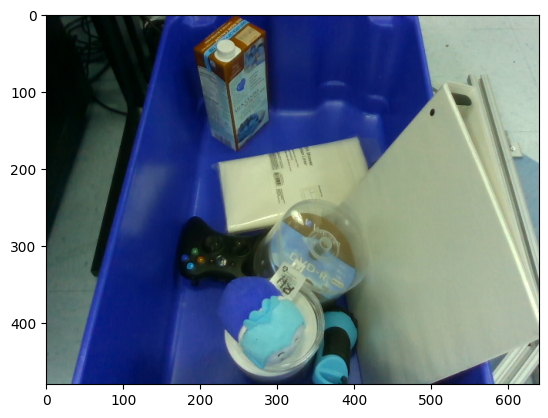

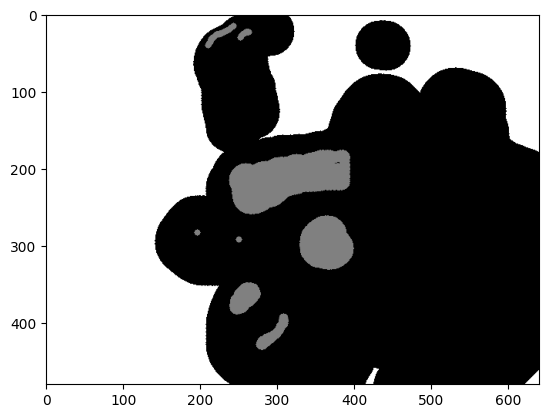

In [12]:
# Load dataset and create dataloader
dataset = SegNetDataset(root_dir='data', transform=tf.ToTensor())


# Create a test, train, validation split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = data.DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = data.DataLoader(val_dataset, batch_size=4, shuffle=True)


# Show sample image and mask
for i, (images, masks) in enumerate(train_loader):
    print(images.shape)
    print(masks.shape)
    # Show first image and mask
    plt.imshow(images[0].permute(1, 2, 0))
    plt.show()
    plt.imshow(masks[0].permute(1, 2, 0))
    plt.show()
    break


## Define the UNet model

In [ ]:
unet = UNet(in_channel=1,out_channel=2)
#out_channel represents number of segments desired
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(unet.parameters(), lr = 0.01, momentum=0.99)
optimizer.zero_grad()       
outputs = unet(inputs)
# permute such that number of desired segments would be on 4th dimension
outputs = outputs.permute(0, 2, 3, 1)
m = outputs.shape[0]
# Resizing the outputs and label to caculate pixel wise softmax loss
outputs = outputs.resize(m*width_out*height_out, 2)
labels = labels.resize(m*width_out*height_out)
loss = criterion(outputs, labels)
loss.backward()
optimizer.step()